In [1]:
import re
from typing import Iterator, Tuple
from pathlib import Path

import numpy as np
from colorama import Fore, Style

from annotation_model import load_annotation, save_annotation, Translation
from data import Flickr30k
from utils import get_current_datetime, show_image


doubt_chars = re.compile(r"\[|\]|")

split = "val"
loader = Flickr30k(split=split)
output_folder = Path(f"./{split}-translations")

In [2]:
def edit_translation(dataset: Flickr30k, image_index: int, caption_index: int):
    image, captions = dataset[image_index]
    try:
        translations: Iterator[Tuple[str, str]] = load_annotation(image_index, caption_index, output_folder)
    except ValueError as e:
        print(str(e))
        return
    show_image(np.asarray(image))
    print("***Editing mode*** (type 'q' to quit editing tis image)")
    print(f"Image #{image_index}, caption #{caption_index}:")
    print(captions[caption_index])
    print("Translations:")
    for i, (marker, sentence) in enumerate(translations):
        print(i, marker, sentence, sep="\t")
    user_input = input("Translation: ")
    if user_input != "q":
        save_annotation(image_index, caption_index, captions[caption_index], user_input, "edit", output_folder)
        return False
    print("Discarding.")
    return True


In [3]:
def annotate(mode="normal", start_at=0):
    if mode == "edit":
        keep_editing = True
        while keep_editing:
            message = "Type image_id and caption_id (e.g., '1 3'): "
            image_id, caption_id = map(int, input(message).split())
            keep_editing = edit_translation(loader, image_id, caption_id)
        return
    for i, (image, captions) in enumerate(loader):
        if i < start_at:
            continue
        show_image(np.asarray(image))
        for j, caption in enumerate(captions):
            result = None
            while result is None:
                print(f"Image #{i}, caption #{j}:")
                print(Fore.GREEN, caption, Style.RESET_ALL)
                before_timestamp = get_current_datetime()
                user_input = input("Translation: ")
                after_timestamp = get_current_datetime()
                if not user_input:
                    print("Empty string is not allowed.")
                    continue
                result = (user_input, mode)
                if user_input[0] == ">":
                    command = user_input[1:]
                    if command == "skip":
                        result = ("", "skip")
                    elif command == "undo":
                        print("Edit previous translation.")
                        previous_caption = (i, j - 1) if j != 0 else (i - 1, 4) 
                        edit_translation(loader, *previous_caption)
                        show_image(np.asarray(image))
                        result = None
                        continue
                elif re.search(doubt_chars, user_input):
                    result = (user_input, "check")
                save_annotation(i, j, caption, *result, output_folder, (before_timestamp, after_timestamp))


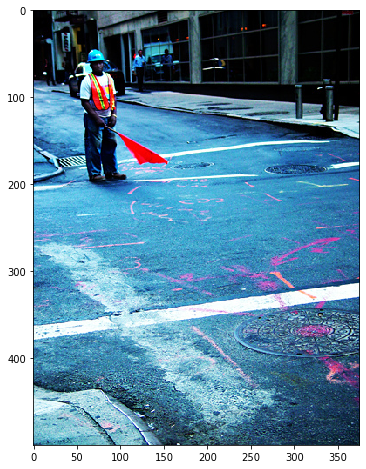

Image #0, caption #0:
  A man in a blue hard hat and orange safety vest stands in an intersection while holding a flag . 
Translation: sobimba
<class 'datetime.datetime'>
Saved img 0, cap 0.
Image #0, caption #1:
  A man wearing a hard hat and a caution vest is standing in the street waving an orange flag . 
Translation: sobemba
<class 'datetime.datetime'>
Saved img 0, cap 1.
Image #0, caption #2:
  A man in bright vest and hard hat holds a flag on a street corner covered in spray paint 


KeyboardInterrupt: 

In [5]:
annotate(mode="normal", start_at=0)